# Setup -- Restart runtime after execution


In [1]:
%%capture
!pip install simpleitk
!pip install -U "monai[all]" pyyaml munch pandas

In [2]:
%%capture
!pip install protobuf==3.9.2
!pip install grpcio
!pip install grpcio-tools
!pip install google-cloud-bigquery
!pip install pydicom
!pip install nibabel
!pip install dcm2niix

In [3]:
%%capture
!pip install 'itkwidgets>=1.0a16'

[dcmqi](https://github.com/QIICR/dcmqi) is an open source library that can help with the conversion between imaging research formats and the standard DICOM representation for image analysis results. More specifically, you can use dcmqi convert DICOM Segmentation objects (DICOM SEG) into research formats, such as NIfTI and NRRD.

In [4]:
%%capture
!wget https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz
!tar zxvf dcmqi-1.2.5-linux.tar.gz
!cp dcmqi-1.2.5-linux/bin/* /usr/local/bin/

In [5]:
%%capture
!pip install -q git-filter-repo

# Auth login

In [6]:
#colab
from google.colab import auth
auth.authenticate_user()

In [7]:
import os
project_id = "namic-prostate"
os.environ["GCP_PROJECT_ID"] = project_id

## MONAI imports

In [ ]:
from google.cloud import bigquery
import pandas as pd
import SimpleITK as sitk
import pydicom
import nibabel as nib
from scipy import ndimage
import numpy as np
import glob
import json
import time

## Data selection: 3 patients from Prostate-MRI-US-Biopsy - with and without ERC

We select T2W, ADC and DWI images for 3 patients that have segmented prostate lesions (segmentation corresponds to T2w images).

In [9]:
# Query

client = bigquery.Client(project=os.environ["GCP_PROJECT_ID"])

query_view = f"""
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,
    StudyDate,
    PatientID,
    SOPInstanceUID,
    # series_aws_url,
    # CONCAT("s3://", SPLIT(gcs_url,"/")[SAFE_OFFSET(2)], "/", crdc_series_uuid, "/*") as aws_location,
    gcs_url,
    SeriesDescription,
    CONCAT("https://viewer.imaging.datacommons.cancer.gov/viewer/", StudyInstanceUID, "?seriesInstanceUID=", SeriesInstanceUID) as viewer_url

  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id = "prostate_mri_us_biopsy" AND
    PatientID IN UNNEST(["Prostate-MRI-US-Biopsy-0001",
                        "Prostate-MRI-US-Biopsy-0002",
                        "Prostate-MRI-US-Biopsy-0003"]) AND
    (SeriesDescription LIKE "%t2%" OR
     SeriesDescription LIKE "%ADC%" OR
     SeriesDescription LIKE "%BVAL%")
  ORDER BY
    PatientID,
    StudyInstanceUID,
    StudyDate,
    SeriesDescription;
"""

start_time = time.time()
job_config = bigquery.QueryJobConfig()
result = client.query(query_view, job_config=job_config)
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time))


elapsed time: 3.8330347537994385


In [10]:
series_df_gt = series_df.copy(deep=True)
SeriesDescription = series_df_gt['SeriesDescription'].values
gt = ["T2_axial" if "t2" in f else f for f in SeriesDescription]
gt = ["DWI" if "BVAL" in f else f for f in gt]
gt = ["ADC" if "ADC" in f else f for f in gt]
series_df_gt['gt'] = gt
# Now only keep rows where gt equals T2_Axial, DWI, or ADC
series_df_gt = series_df_gt[series_df_gt['gt'].isin(["T2_axial", "DWI", "ADC"])]

In [11]:
# Pick 3 patients to analyze

PatientID_df = series_df_gt[['PatientID']]
PatientID_df = PatientID_df.drop_duplicates()
PatientID_list = list(PatientID_df['PatientID'].values)
PatientID_list_keep = PatientID_list

series_df_analyze = series_df_gt[series_df_gt['PatientID'].isin(PatientID_list_keep)]

print(len(set(series_df_analyze['PatientID'].values)))
print(len(set(series_df_analyze['StudyInstanceUID'].values)))
print(len(set(series_df_analyze['SeriesInstanceUID'].values)))

3
3
9


In [12]:
collection_id = "Prostate-MRI-US-Biopsy"

In [13]:
series_list = set(series_df_analyze['SeriesInstanceUID'].values)
num_series = len(series_list)
print('num_series: ' + str(num_series))

num_series: 9


## Data download and convert to Nifti

In [14]:

nifti_directory = "/content/nifti"
if not os.path.exists(nifti_directory):
  os.mkdir(nifti_directory)
dicom_directory = "/content/dicom"
if not os.path.exists(dicom_directory):
  os.mkdir(dicom_directory)

final_nii_directory = os.path.join(nifti_directory, collection_id, "nii")
if not os.path.exists(final_nii_directory):
  os.makedirs(final_nii_directory)

temp_nii_directory = os.path.join(nifti_directory, "temp")
if not os.path.exists(temp_nii_directory):
  os.makedirs(temp_nii_directory)

for series_index, series in enumerate(series_list):

  print('series_index: ' + str(series_index))
  print('series: ' + str(series))

  series_df_analyze_keep = series_df_analyze[series_df_analyze['SeriesInstanceUID']==series]

  PatientID = str(series_df_analyze_keep['PatientID'].values[0])
  print('PatientID: ' + PatientID)
  scan = str(series_df_analyze_keep['gt'].values[0])
  print('scan: ' + scan)
  StudyDate = str(series_df_analyze_keep['StudyDate'].values[0])
  print('StudyDate: ' + StudyDate)

  output_nii_directory = os.path.join(final_nii_directory, PatientID + '_' + StudyDate)
  output_dicom_directory = os.path.join(dicom_directory, collection_id, PatientID + '_' + StudyDate, scan)

  if not os.path.isdir(output_nii_directory):
    os.makedirs(output_nii_directory)
  if not os.path.isdir(output_dicom_directory):
    os.makedirs(output_dicom_directory)

  start_time = time.time()
  gs_file_path = "/content/gcs_paths.txt"
  series_df_analyze_keep["gcs_url"].to_csv(gs_file_path, header = False, index = False)
  !cat $gs_file_path | gsutil -q -m cp -Ir $output_dicom_directory
  elapsed = time.time() - start_time
  print ("Done download in %g seconds."%elapsed)

  # convert to nifti
  cmd = 'dcm2niix -z y -m y -o %s  %s ' % (temp_nii_directory, output_dicom_directory)
  print(cmd)
  ret = os.system(cmd)
  print(ret)

  # rename
  nii_file_orig = [os.path.join(temp_nii_directory,f) for f in os.listdir(temp_nii_directory) if f.endswith('.nii.gz')][0]
  nii_file = os.path.join(output_nii_directory, PatientID + '_' + StudyDate + '_' + scan + ".nii.gz")

  os.rename(nii_file_orig, nii_file)
  print('nii_file_orig: ' + str(nii_file_orig))
  print('nii_file: ' + str(nii_file))



series_index: 0
series: 1.3.6.1.4.1.14519.5.2.1.162068516448609870953900942709102912553
PatientID: Prostate-MRI-US-Biopsy-0003
scan: DWI
StudyDate: 2009-03-22
Done download in 9.73498 seconds.
dcm2niix -z y -m y -o /content/nifti/temp  /content/dicom/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0003_2009-03-22/DWI 
0
nii_file_orig: /content/nifti/temp/DWI_ep2d-advdiff-3Scan-4bval_spair_std_20090322091321_9.nii.gz
nii_file: /content/nifti/Prostate-MRI-US-Biopsy/nii/Prostate-MRI-US-Biopsy-0003_2009-03-22/Prostate-MRI-US-Biopsy-0003_2009-03-22_DWI.nii.gz
series_index: 1
series: 1.3.6.1.4.1.14519.5.2.1.268419299297710555980777749963775398985
PatientID: Prostate-MRI-US-Biopsy-0001
scan: ADC
StudyDate: 2009-06-28
Done download in 9.43618 seconds.
dcm2niix -z y -m y -o /content/nifti/temp  /content/dicom/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001_2009-06-28/ADC 
0
nii_file_orig: /content/nifti/temp/ADC_ep2d-advdiff-3Scan-4bval_spair_std_20090628093912_5.nii.gz
nii_file: /content/nift

## Resample the DWI and ADC files to T2

In [15]:
def resample_image(input_image, reference_image):
    # Get the transformation from the input image to the reference image
    transform = sitk.Transform()

    # Use the resampling filter
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetTransform(transform)  # You may want to set a proper transform here if needed
    resampler.SetSize(reference_image.GetSize())
    resampler.SetOutputSpacing(reference_image.GetSpacing())
    resampler.SetOutputOrigin(reference_image.GetOrigin())
    resampler.SetOutputDirection(reference_image.GetDirection())

    # Perform the resampling
    output_image = resampler.Execute(input_image)

    return output_image

In [16]:
list_all_patient_dirs = [os.path.join(final_nii_directory, f) for f in os.listdir(final_nii_directory) if os.path.isdir(os.path.join(final_nii_directory, f))]

for patient_dir in list_all_patient_dirs:
  T2_filename = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir) if f.endswith('T2_axial.nii.gz')][0]
  ADC_filename = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir) if f.endswith('ADC.nii.gz')][0]
  DWI_filename = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir) if f.endswith('DWI.nii.gz')][0]

  ADC_resampled_filename = ADC_filename.replace("ADC.nii.gz", "ADC_resampled_to_T2_itk.nii.gz")
  DWI_resampled_filename = DWI_filename.replace("DWI.nii.gz", "DWI_resampled_to_T2_itk.nii.gz")

  ### resample ADC to T2 using ITK ###

  # read T2
  reader = sitk.ImageFileReader()
  reader.SetImageIO("NiftiImageIO")
  reader.SetFileName(T2_filename)
  t2_image = reader.Execute()
  t2_image = sitk.Cast(t2_image, sitk.sitkFloat32)

  # read ADC
  reader = sitk.ImageFileReader()
  reader.SetImageIO("NiftiImageIO")
  reader.SetFileName(ADC_filename)
  adc_image = reader.Execute()
  adc_image = sitk.Cast(adc_image, sitk.sitkFloat32)

  # resample
  adc_image_resampled_to_t2 = resample_image(adc_image, t2_image)

  # save as nifti
  writer = sitk.ImageFileWriter()
  writer.SetFileName(ADC_resampled_filename)
  writer.Execute(adc_image_resampled_to_t2)

  ### resample DWI to T2 using ITK ###

  # read DWI
  reader = sitk.ImageFileReader()
  reader.SetImageIO("NiftiImageIO")
  reader.SetFileName(DWI_filename)
  dwi_image = reader.Execute()
  dwi_image = sitk.Cast(dwi_image, sitk.sitkFloat32)

  # resample
  dwi_image_resampled_to_t2 = resample_image(dwi_image, t2_image)

  # save as nifti
  writer = sitk.ImageFileWriter()
  writer.SetFileName(DWI_resampled_filename)
  writer.Execute(dwi_image_resampled_to_t2)


In [17]:
# remove temp nifti files
!rm -r /content/nifti/temp/*


## Get lesion segmentation for these patients

In [18]:
# Query

client = bigquery.Client(project=os.environ["GCP_PROJECT_ID"])

query_view = f"""
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,
    StudyDate,
    PatientID,
    SOPInstanceUID,
    gcs_url,
    SeriesDescription,
  FROM
    `bigquery-public-data.idc_current.dicom_all`
  WHERE
    collection_id = "prostate_mri_us_biopsy" AND
    Modality = "SEG" AND
    # SeriesDescription LIKE "%T2 Weighted Axial Segmentations%" AND
    SeriesDescription LIKE "%Segmentation of prostate lesion 1%" AND
    PatientID IN UNNEST(@PatientID_list_keep)
  ORDER BY
    PatientID,
    StudyInstanceUID,
    StudyDate,
    SeriesDescription;
"""

start_time = time.time()
job_config = bigquery.QueryJobConfig(query_parameters=[
        bigquery.ArrayQueryParameter("PatientID_list_keep", "STRING", PatientID_list_keep),
    ])
result = client.query(query_view, job_config=job_config)
series_df = result.to_dataframe(create_bqstorage_client=True)
end_time = time.time()
print ('elapsed time: ' + str(end_time-start_time))

elapsed time: 3.6910102367401123


In [19]:
series_list_seg = series_df['SeriesInstanceUID'].values

In [20]:
# Download and convert

final_nii_seg_directory = os.path.join(nifti_directory, collection_id, "nii_seg")
if not os.path.exists(final_nii_seg_directory):
  os.makedirs(final_nii_seg_directory)

for series_index, series in enumerate(series_list_seg):

  print('series_index: ' + str(series_index))
  print('series: ' + str(series))

  series_df_analyze_keep = series_df[series_df['SeriesInstanceUID']==series]

  PatientID = str(series_df_analyze_keep['PatientID'].values[0])
  print('PatientID: ' + PatientID)
  StudyDate = str(series_df_analyze_keep['StudyDate'].values[0])
  print('StudyDate: ' + StudyDate)

  output_nii_directory = os.path.join(final_nii_seg_directory, PatientID + '_' + StudyDate)
  output_dicom_directory = os.path.join(dicom_directory, PatientID + '_' + StudyDate)

  if not os.path.isdir(output_nii_directory):
    os.makedirs(output_nii_directory)
  if not os.path.isdir(output_dicom_directory):
    os.makedirs(output_dicom_directory)

  start_time = time.time()
  gs_file_path = "/content/gcs_paths.txt"
  series_df_analyze_keep["gcs_url"].to_csv(gs_file_path, header = False, index = False)
  !cat $gs_file_path | gsutil -q -m cp -Ir $output_dicom_directory
  elapsed = time.time() - start_time
  print ("Done download in %g seconds."%elapsed)

  # change name of dicom seg file
  seg_file_input = [os.path.join(output_dicom_directory,f) for f in os.listdir(output_dicom_directory)][0]
  seg_file_output = os.path.join(output_dicom_directory,'seg.dcm')
  !mv $seg_file_input $seg_file_output

  # convert to nifti
  !segimage2itkimage --prefix "segment" --outputType nifti --outputDirectory $output_nii_directory --inputDICOM $seg_file_output

  # rename nii files with labels.
  nii_files = sorted([os.path.join(output_nii_directory,f) for f in os.listdir(output_nii_directory) if f.startswith('segment') and f.endswith('.nii.gz')])
  num_nii_files = len(nii_files)
  print('num_files: ' + str(num_nii_files))
  # rename according to segments in json file
  meta_json_filename = os.path.join(output_nii_directory, 'segment-meta.json')
  f = open(meta_json_filename)
  metadata = json.load(f)['segmentAttributes']
  num_segments = len(metadata)
  for m in range(0,num_segments):
    input_filename = nii_files[m]
    output_filename = os.path.join(output_nii_directory, metadata[m][0]['SegmentLabel'].strip()+'.nii.gz')
    print(input_filename)
    print(output_filename)
    os.rename(input_filename, output_filename)



series_index: 0
series: 1.2.276.0.7230010.3.1.3.0.45565.1698537457.857823
PatientID: Prostate-MRI-US-Biopsy-0001
StudyDate: 2009-06-28
Done download in 4.41779 seconds.
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 1 0 0
Col direction: 0 1 0
Z direction: 0 0 1
Total frames: 60
Total frames with unique IPP: 60
Total overlapping frames: 0
Origin: [-107.932, -66.0445, -74.8811]
num_files: 1
/content/nifti/Prostate-MRI-US-Biopsy/nii_seg/Prostate-MRI-US-Biopsy-0001_2009-06-28/segment-1.nii.gz
/content/nifti/Prostate-MRI-US-Biopsy/nii_seg/Prostate-MRI-US-Biopsy-0001_2009-06-28/Lesion 1.nii.gz
series_index: 1
series: 1.2.276.0.7230010.3.1.3.0.45171.1698537292.711081
PatientID: Prostate-MRI-US-Biopsy-0002
StudyDate: 2009-03-26
Done download in 4.52259 seconds.
dcmqi repository URL: git@github.com:QIICR/dcmqi.git revision: 1153738 tag: v1.2.5
Row direction: 0.999848 0 -0.0174524
Col direction: 0 1 0
Z direction: 0.0174524 -0 0.999848
Total fra

# Setup of working directory for inference using MONAI prostate158 cancer model

In [21]:
!rm -rf monai_pcdetection_bundle

Definition of inference paths in our local environment.

In [61]:
#Definition of paths
os.environ["monai_workspace"] = "monai_pcdetection_bundle"
os.environ["monai_workspace_eval"] = os.path.join(os.environ["monai_workspace"], "eval/")
os.environ["monai_workspace_dataset"] = os.path.join(os.environ["monai_workspace"], "dataset/")
os.environ["monai_workspace_model_dir"] = os.path.join(os.environ["monai_workspace"], "models")
os.environ["monai_workspace_model_path"] = os.path.join(os.environ["monai_workspace"], "models", "cancer.pt")
os.environ["monai_workspace_config_dir"] = os.path.join(os.environ["monai_workspace"], "configs")

In [62]:
#Make sure these folders exists, otherwise create
!mkdir -p {os.environ["monai_workspace"]}
!mkdir -p {os.environ["monai_workspace_eval"]}
!mkdir -p {os.environ["monai_workspace_dataset"]}
!mkdir -p {os.environ["monai_workspace_model_dir"]}

Download PC segmentation bundle from github.
Move it into bundle config folder. The bundle contains configuration files that we will modify to indicate the source files for the inference (datalist.json, inference.json).

In [ ]:
%%capture
!git clone --depth 1 --branch main https://github.com/ImagingDataCommons/idc-prostate-mri-analysis.git
%cd idc-prostate-mri-analysis
!git filter-repo --subdirectory-filter pcDetectionBundle
!cp -r ./configs ../monai_pcdetection_bundle/
%cd ..
!rm -r idc-prostate-mri-analysis

Download pre-trained PC model to local model path : bundle/models/placeholder.pt

In [ ]:
%%capture
!wget https://zenodo.org/records/6397057/files/tumor.pt
!mv /content/tumor.pt {os.environ["monai_workspace_model_dir"]}/cancer.pt


Copy T2,ADC,DWI data as an input for the inference pipeline.

Since we are dealing with multi-modality input data([t2,adc,dwi]), monai bundle expects a certain format :


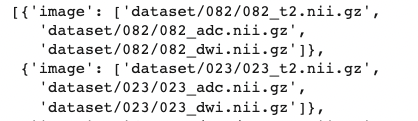

Please also keep in mind that the loading method used here needs relative paths to the bundle root folder to work properly, not absolute paths.

During inference, writing to disk of the model ouputs only takes into account the file name, so please make sure your input nifti samples have different naming, even across modalities of the same sample, convention used here is caseID_modality.nii.gz

The pipeline below showcases :

input_nifti_data_paths

**-->**

```
[[caseID1_t2.nii.gz, caseID1_adc.nii.gz, caseID1_dwi.nii.gz],

[caseID2_t2.nii.gz, caseID2_adc.nii.gz, caseID2_dwi.nii.gz],...]
```

**-->** dump to json : datalist.json


This datalist.json is later loaded in the inference.json and looks like this :



```
{"testing" : [relative_path/caseID1_t2.nii.gz, relative_path/caseID1_adc.nii.gz, relative_pathcaseID1_dwi.nii.gz],

[relative_path/caseID2_t2.nii.gz, relative_path/caseID2_adc.nii.gz, relative_path/caseID2_dwi.nii.gz],...}
```




Move nifti files to be analyzed to monai workspaces folder

In [73]:
!cp -r '/content/nifti/Prostate-MRI-US-Biopsy' {os.environ['monai_workspace_dataset']}/

In [ ]:
eval_lst = list(zip(sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'], "Prostate-MRI-US-Biopsy/nii/*/*T2_axial.nii.gz"))),
         sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'],"Prostate-MRI-US-Biopsy/nii/*/*DWI_resampled_to_T2_itk.nii.gz"))),
         sorted(glob.glob(os.path.join(os.environ['monai_workspace_dataset'], "Prostate-MRI-US-Biopsy/nii/*/*ADC_resampled_to_T2_itk.nii.gz")))))

for x in eval_lst :
    assert os.path.exists(x[0])
    assert os.path.exists(x[1])
    assert os.path.exists(x[2])

eval_lst = [(x[0].replace(os.environ['monai_workspace'], "/content/" + os.environ['monai_workspace']),
             x[1].replace(os.environ['monai_workspace'], "/content/" + os.environ['monai_workspace']),
             x[2].replace(os.environ['monai_workspace'], "/content/" + os.environ['monai_workspace'])) for x in eval_lst]




In [75]:
!rm -rf {os.path.join(os.environ["monai_workspace"], 'datalist.json')}

In [76]:
for index, item in enumerate(eval_lst) :
  eval_lst[index]={"image" : item}
with open(os.path.join(os.environ["monai_workspace"],'datalist.json'), 'w') as fp:
  json.dump({"testing" : eval_lst}, fp)


To use the bundle on our own data, we need to modify the inference.json file from the bundle.

The variables that we need to modify are the locations of the data, model and output directories paths.


In [79]:
inference_json = json.load(open(os.path.join(os.environ["monai_workspace_config_dir"], "inference.json")))
#setup variables
inference_json["bundle_root"] = os.environ["monai_workspace"]
inference_json["output_dir"] = os.environ["monai_workspace_eval"]
inference_json["dataset_dir"] = os.environ["monai_workspace_dataset"]
inference_json["handlers"][0]["load_path"] = os.environ["monai_workspace_model_path"]
inference_json["test_datalist"] = "$monai.data.load_decathlon_datalist('/content/monai_pcdetection_bundle/datalist.json', data_list_key='testing')"

Overriding of inference.json to local workspace

In [80]:
with open(os.environ["monai_workspace_config_dir"]+"/inference.json", 'w') as fp:
    json.dump(inference_json, fp, indent=4)

# Inference

In [81]:
!python -m monai.bundle run evaluating --meta_file /content/monai_pcdetection_bundle/configs/metadata.json --config_file /content/monai_pcdetection_bundle/configs/inference.json

2024-02-02 09:17:09.337543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 09:17:09.337613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 09:17:09.339039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 09:17:09.347034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 09:17:10.496213: W tensorflow/comp